# Analysis Development
 - Given the user has access to Spotify, this script will return a simple plot of their liked songs grouped by day and number of songs liked per day
 - Additional updated research will be appended in here

##### Import the modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import spotipy
from spotipy import SpotifyOAuth

##### Client ID and Secret are passed from an external source

In [3]:
import settings

In [4]:
# Client ID and Client Secret is called and used
spotify_client_id = settings.SPOTIFY_CLIENT_ID
spotify_client_secret = settings.SPOTIFY_CLIENT_SECRET
spotify_redirect_uri = "http://localhost:5000/callback"

##### With the application setup, we just need to call in the authenticator and method itself
 - This will vary based on the type of access. For me, it is suitable.

In [5]:
# provide scope of access for Python which requests access from the current user
scope =  'user-library-read user-top-read user-read-private playlist-read-private playlist-read-collaborative playlist-modify-public playlist-modify-private'

# authentication manager ensures secured point of access from spotify to python to client (me)
auth_manager = SpotifyOAuth(
                            scope = scope, 
                            client_id = spotify_client_id,
                            client_secret = spotify_client_secret,
                            redirect_uri = spotify_redirect_uri
                            )

# initial call of spotify using authentication manager
sp = spotipy.Spotify(auth_manager = auth_manager)

##### Test connection (expectancy of a dict response with personal info)

In [108]:
# sp.current_user()

##### Users Top Tracks

In [7]:
sp.current_user_top_tracks()

{'items': [{'album': {'album_type': 'SINGLE',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4iMO20EPodreIaEl8qW66y'},
      'href': 'https://api.spotify.com/v1/artists/4iMO20EPodreIaEl8qW66y',
      'id': '4iMO20EPodreIaEl8qW66y',
      'name': 'Still Woozy',
      'type': 'artist',
      'uri': 'spotify:artist:4iMO20EPodreIaEl8qW66y'}],
    'available_markets': ['AR',
     'AU',
     'AT',
     'BE',
     'BO',
     'BR',
     'BG',
     'CA',
     'CL',
     'CO',
     'CR',
     'CY',
     'CZ',
     'DK',
     'DO',
     'DE',
     'EC',
     'EE',
     'SV',
     'FI',
     'FR',
     'GR',
     'GT',
     'HN',
     'HK',
     'HU',
     'IS',
     'IE',
     'IT',
     'LV',
     'LT',
     'LU',
     'MY',
     'MT',
     'MX',
     'NL',
     'NZ',
     'NI',
     'NO',
     'PA',
     'PY',
     'PE',
     'PH',
     'PL',
     'PT',
     'SG',
     'SK',
     'ES',
     'SE',
     'CH',
     'TW',
     'TR',
     'UY',
     'US',
     'GB',
 

##### While loop to collect all songs in my liked

In [8]:
liked_songs = []
offset = 0
users_liked = sp.current_user_saved_tracks(limit = 50)

while users_liked["next"] != None:
    liked_songs.extend(users_liked["items"])
    offset+=50
    users_liked = sp.current_user_saved_tracks(offset=offset,limit = 50)

liked_songs.extend(users_liked["items"])

##### Observed collection of my liked songs 

In [9]:
len(liked_songs)

1810

In [10]:
df = pd.DataFrame(list(map(lambda x: x["track"],liked_songs)))

In [11]:
df2 = pd.DataFrame(liked_songs)

In [12]:
df["added_at"] = pd.to_datetime(df2["added_at"]).dt.strftime('%Y-%m-%dT%H:%M:%SZ')


In [13]:
# df["release_date"] = df["album"].apply(lambda x: x["release_date"])
df["release_date"] = pd.to_datetime(df["album"].apply(lambda x: x["release_date"]), format='ISO8601').dt.strftime('%Y-%m-%d')

In [14]:
from datetime import datetime, timezone
df["added_at"] = pd.to_datetime(df["added_at"], format= 'ISO8601')
df["release_date"] = pd.to_datetime(df["release_date"], format= 'ISO8601')

In [15]:
df["added_at"] = pd.to_datetime(df["added_at"].dt.strftime('%Y-%m-%d'))

In [16]:
df["date_difference"] = (df["added_at"]-df["release_date"]).dt.days

In [17]:
# df["added_at"].dt.day
# df["added_at"].dt.month
# df["added_at"].dt.year

# df2 = df["added_at"].dt.month
date_grouped = df.groupby("added_at").count()

In [18]:
daily_songs_liked = date_grouped['id'].reset_index()
daily_songs_liked['month'] = daily_songs_liked['added_at'].dt.month
daily_songs_liked['year'] = daily_songs_liked['added_at'].dt.year
monthly_songs_liked = daily_songs_liked.groupby(["year", "month"]).agg({'id':np.sum}).reset_index()

C:\Users\nsung\AppData\Local\Temp\ipykernel_36140\2890141356.py:4: FutureWarning: The provided callable <function sum at 0x000001F02D361440> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  monthly_songs_liked = daily_songs_liked.groupby(["year", "month"]).agg({'id':np.sum}).reset_index()


Text(0.5, 1.0, 'My Liked Songs from Spotify')

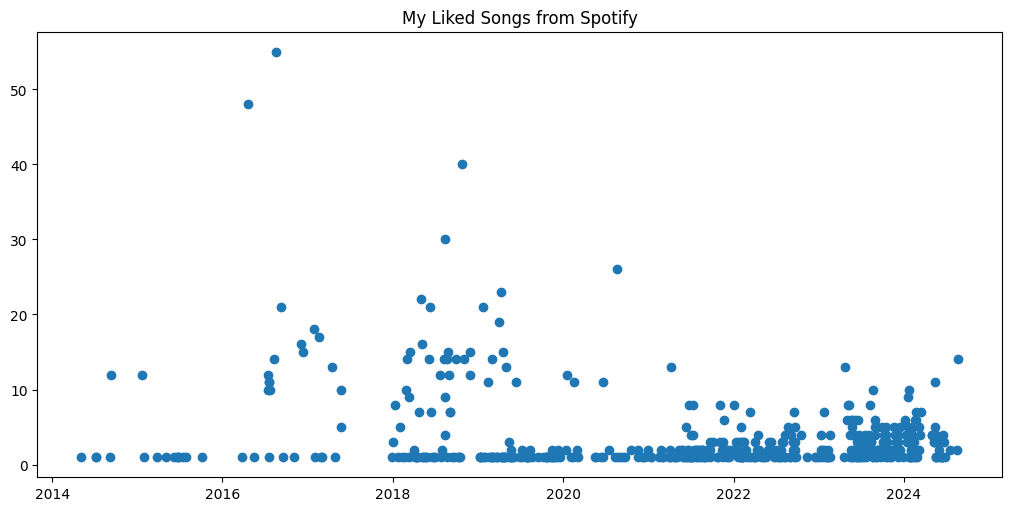

In [19]:
# date_grouped["id"]
fig, ax = plt.subplots(figsize=(10,5), layout = 'constrained')
ax.scatter('added_at', 'id', data = date_grouped['id'].reset_index())
ax.set_title("My Liked Songs from Spotify")

##### Second Visual

In [163]:
x,y,z = monthly_songs_liked['year'], monthly_songs_liked['month'], monthly_songs_liked['id']

In [124]:
daily_songs_liked.index = daily_songs_liked['added_at']

In [239]:
# daily_songs_liked.groupby(['year','month']).agg({"id":np.sum}).pivot(index=, columns = 'month',values = 'id')
# daily_songs_liked.pivot(index = daily_songs_liked['year'], columns =daily_songs_liked['month'].unique(), values = 'id')
df.columns

Index(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms',
       'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local',
       'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri',
       'added_at', 'release_date', 'date_difference'],
      dtype='object')

In [23]:
dt_names = ['added_at','release_date']
for name in dt_names:
    df[f'{name}_year'] = df[name].dt.year
    df[f'{name}_month'] = df[name].dt.month
    df[f'{name}_day'] = df[name].dt.day

In [106]:
df.columns

pivotted = df.groupby([df['added_at_month'], df['added_at_year']])['added_at'].apply(list).apply(len).unstack().fillna(0)

y = np.vstack([pivotted[i] for i in pivotted.columns])

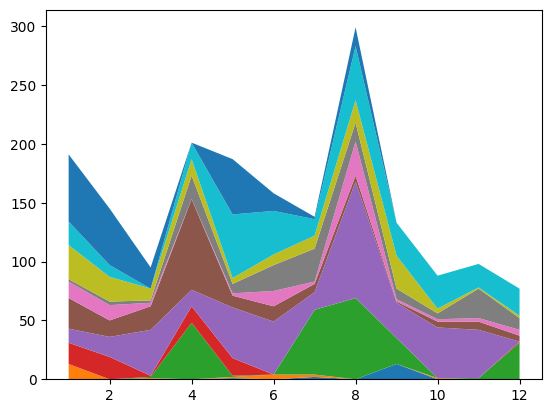

In [107]:
fig, ax = plt.subplots()
ax.stackplot(pivotted.index, y, labels = pivotted.keys())
# list(pivotted.keys())
# pivotted.values
# pivotted
plt.show()

TypeError: matplotlib.axes._axes.Axes.fill_between() got multiple values for keyword argument 'label'

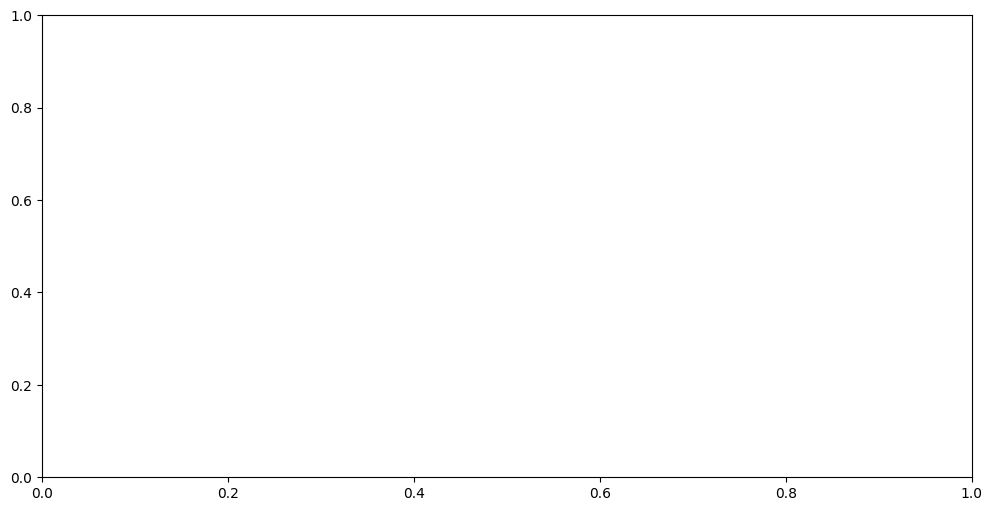

In [179]:
fig, ax = plt.subplots(figsize=(12, 6))

for year, year_data in grouped_by_year:
    # Prepare data for this year (similar to the original steps)
    pivot_data_year = year_data.pivot(index='added_at', columns='month', values='id').fillna(0)

    # Create stackplot for this year
    ax.stackplot(pivot_data_year.index, pivot_data_year.values.T, label=f"Year {year}")

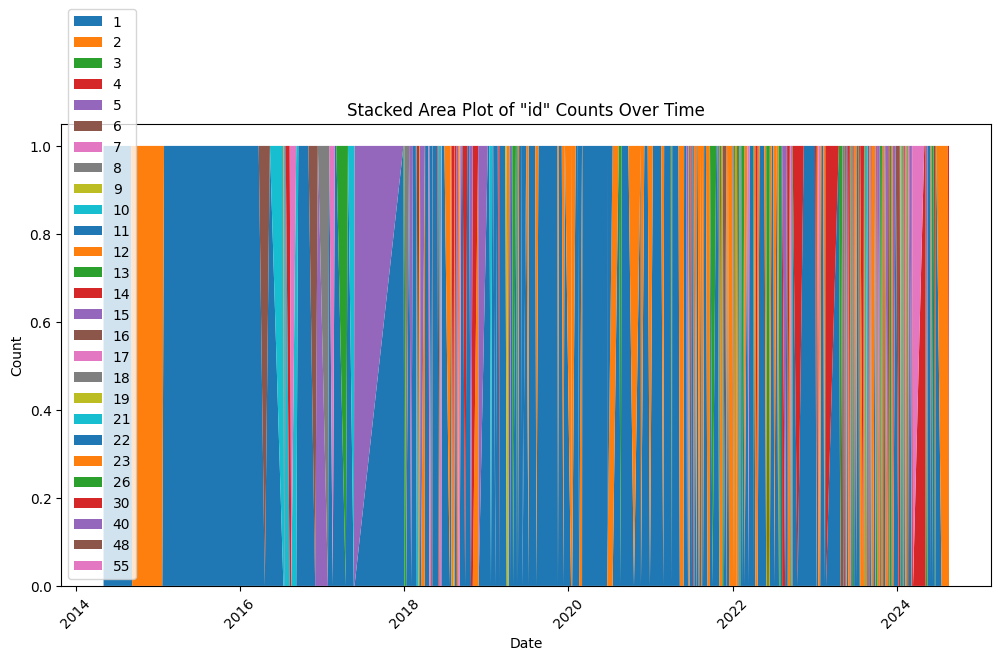

In [169]:
plt.figure(figsize=(12, 6))
plt.stackplot(pivot_data.index, pivot_data.values.T)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Stacked Area Plot of "id" Counts Over Time')
plt.xticks(rotation=45)
plt.legend(pivot_data.columns)
plt.show()